In [1]:
import os,sys
import json
import torch

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

In [2]:
# 构建数据集
from torch.utils.data import DataLoader,Subset
from src.dataset import build_global_vocab_and_maxcount, CLEVRMultiLabelByImage

clevr_root = "../CLEVR_v1.0"

# 全局统计：colors/shapes/max_objects（train+val+test）
colors, shapes, max_objects, _ = build_global_vocab_and_maxcount(clevr_root, splits=("train","val"))

print("num_colors:", len(colors), colors)
print("num_shapes:", len(shapes), shapes)
print("max_objects:", max_objects)

train_ds = CLEVRMultiLabelByImage(
    clevr_root=clevr_root,
    split="train",
    colors=colors,
    shapes=shapes,
    max_objects=max_objects,
)

small_data = Subset(train_ds, range(32))
train_dl = DataLoader(train_ds, batch_size=100, shuffle=True, num_workers=0)

images, color_mh, shape_mh, count_oh, img_fns = next(iter(train_dl))
print("images:", images.shape)
print("color_mh:", color_mh.shape)   # [B, num_colors]
print("shape_mh:", shape_mh.shape)   # [B, num_shapes]
print("count_oh:", count_oh.shape)   # [B, max_objects+1]
print("example fn:", img_fns[0])
print("example count one-hot argmax:", int(count_oh[0].argmax()))

num_colors: 8 ['blue', 'brown', 'cyan', 'gray', 'green', 'purple', 'red', 'yellow']
num_shapes: 3 ['cube', 'cylinder', 'sphere']
max_objects: 10
images: torch.Size([100, 3, 224, 224])
color_mh: torch.Size([100, 8])
shape_mh: torch.Size([100, 3])
count_oh: torch.Size([100, 11])
example fn: CLEVR_train_028897.png
example count one-hot argmax: 9


In [3]:
# 构建模型
from src.model import REVAE_V1

revae = REVAE_V1()


In [4]:
from src.train import TrainConfig, fit, evaluate
import torch.optim as optim

cfg = TrainConfig(
    epochs=10,
    lr=1e-3,
    beta_kl=1,
    lam_color=0,
    lam_shape=0,
    lam_count=0,
    recon_loss="bce_logits",   # 你已确认 images 在 [0,1] bce_logits\mse\l1
    use_amp=False,
    log_every=100,
    save_best=False,
    ckpt_dir="../checkpoints",
    ckpt_name="revae_v2.pt",
    device="cuda" if torch.cuda.is_available() else "cpu",
)

optimizer = optim.Adam(revae.parameters(), lr=cfg.lr)

# 若你还没做 val_dl，可以先 val_loader=None
result = fit(revae, train_dl, optimizer, cfg, val_loader=None)
print(result["ckpt_path"])


epoch1


d:\github file\REVAE\src\train.py:137: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and device.type == "cuda"))
d:\github file\REVAE\src\train.py:152: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):


[train] epoch 1 step 0/700 total=113803.2266 recon=113802.9609 kl=0.2647 loss_color=0.0000 loss_shape=0.0000 loss_count=0.0000
[train] epoch 1 step 100/700 total=103110.3906 recon=102987.4375 kl=122.9548 loss_color=0.0000 loss_shape=0.0000 loss_count=0.0000
[train] epoch 1 step 200/700 total=102936.2422 recon=102870.5156 kl=65.7277 loss_color=0.0000 loss_shape=0.0000 loss_count=0.0000
[train] epoch 1 step 300/700 total=102820.4062 recon=102768.8594 kl=51.5507 loss_color=0.0000 loss_shape=0.0000 loss_count=0.0000
[train] epoch 1 step 400/700 total=102676.5078 recon=102554.8203 kl=121.6905 loss_color=0.0000 loss_shape=0.0000 loss_count=0.0000
[train] epoch 1 step 500/700 total=102646.7031 recon=102590.1406 kl=56.5633 loss_color=0.0000 loss_shape=0.0000 loss_count=0.0000
[train] epoch 1 step 600/700 total=102552.2734 recon=102503.6172 kl=48.6561 loss_color=0.0000 loss_shape=0.0000 loss_count=0.0000
epoch2
[train] epoch 2 step 0/700 total=102369.8359 recon=102320.3750 kl=49.4619 loss_color

In [ ]:
import torch
from src.model import REVAE_V1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_path = "../checkpoints/revae_v1.pt"  # 你的实际路径
revae = REVAE_V1().to(device)

ckpt = torch.load(ckpt_path, map_location=device)

# 如果你保存的是 {"model": state_dict, ...}
if isinstance(ckpt, dict) and "model" in ckpt:
    revae.load_state_dict(ckpt["model"])
else:
    # 如果你保存的就是纯 state_dict
    revae.load_state_dict(ckpt)

revae.eval()
print("Loaded checkpoint from:", ckpt_path)


Loaded checkpoint from: ../checkpoints/revae_v2.pt


C:\Users\cyh\AppData\Local\Temp\ipykernel_28160\2557651338.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


In [10]:
# 取第 i 张（你可以换 i）
i = 110
image, color_mh, shape_mh, count_oh, img_fn = train_ds[i]

print("file:", img_fn)
print("gt count:", int(count_oh.argmax()))


file: CLEVR_train_000110.png
gt count: 3


In [11]:
import torch.nn.functional as F

def decode_multihot(mh, names, thr=0.5):
    """mh: (K,) in {0,1} or prob; names: list[str] length K"""
    idx = (mh >= thr).nonzero(as_tuple=True)[0].tolist()
    return [names[j] for j in idx]

with torch.no_grad():
    x = image.unsqueeze(0).to(device)  # (1,3,224,224)

    out = revae(x)
    if isinstance(out, (tuple, list)) and len(out) == 3:
        x_logits, post, heads = out
    else:
        # 如果你 forward 返回 dict
        x_logits, post, heads = out["x_logits"], out["post"], out["heads"]

    p = torch.sigmoid(x_logits)
    print("pred mean:", p.mean().item(), "pred max:", p.max().item(), "pred min:", p.min().item())
    print("gt mean:", images.mean().item(), "gt max:", images.max().item(), "gt min:", images.min().item())
    # --- 预测 ---
    color_prob = torch.sigmoid(heads["color_logits"])[0].detach().cpu()  # (8,)
    shape_prob = torch.sigmoid(heads["shape_logits"])[0].detach().cpu()  # (3,)
    count_pred = heads["count_logits"].argmax(dim=1)[0].item()           # int 0..10

    # --- 重建 ---
    recon = torch.sigmoid(x_logits)[0].detach().cpu()  # (3,224,224) in [0,1]

print("Pred count:", count_pred)
print("Pred colors:", decode_multihot(color_prob, colors, thr=0.5))
print("Pred shapes:", decode_multihot(shape_prob, shapes, thr=0.5))

gt_colors = decode_multihot(color_mh, colors, thr=0.5)
gt_shapes = decode_multihot(shape_mh, shapes, thr=0.5)
gt_count  = int(count_oh.argmax())

print("GT count:", gt_count)
print("GT colors:", gt_colors)
print("GT shapes:", gt_shapes)

pred mean: 0.4714866578578949 pred max: 0.6356167197227478 pred min: 0.1302252560853958
gt mean: 0.45908698439598083 gt max: 1.0 gt min: 0.007843137718737125
Pred count: 3
Pred colors: ['brown', 'gray', 'red', 'yellow']
Pred shapes: ['cube', 'cylinder']
GT count: 3
GT colors: ['blue', 'green']
GT shapes: ['cube', 'cylinder', 'sphere']


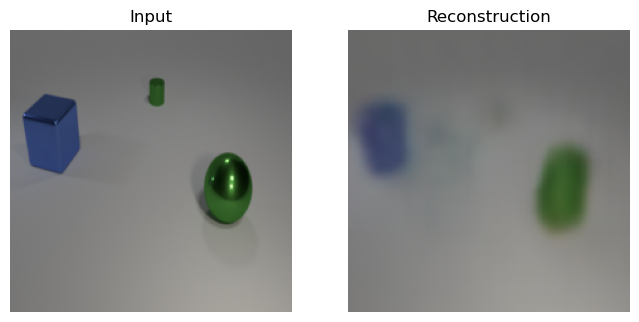

In [12]:
import matplotlib.pyplot as plt

def show_img(t):
    # t: (3,H,W) in [0,1]
    t = t.permute(1,2,0).numpy()
    plt.imshow(t)
    plt.axis("off")

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Input")
show_img(image)          # dataset 给的 image 通常已是 [0,1]

plt.subplot(1,2,2)
plt.title("Reconstruction")
show_img(recon)

plt.show()
